<a href="https://colab.research.google.com/github/BAltundas/Testing-Pycharm/blob/master/pymc3_Occupancy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Bayesian logistic regression with PyMC3**

Reference: [Bayesian logistic regression with PyMC3](https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a)

Data:[Occupancy Detection](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)

We will solve a `classification problem` from end to end with PyMC3. More precisely, we will use PyMC3 to do Bayesian logistic regression using the public dataset above. The dataset contains several variables such as light, temperature, humidity, and CO2 levels. The goal is to detect a room’s occupancy from these variables.

In [ ]:
!pip install arviz

     |████████████████████████████████| 1.5MB 12.3MB/s 
     |████████████████████████████████| 737kB 50.4MB/s 
     |████████████████████████████████| 4.7MB 49.0MB/s 
     |████████████████████████████████| 296kB 53.1MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix


In [ ]:
import arviz as az

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving datatest.txt to datatest.txt


In [ ]:
df=pd.read_csv('datatest.txt')
df.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2507,2015-02-04 05:45:59,20.600000,24.390000,0.0,468.200000,0.003655,0
1023,2015-02-03 05:02:00,20.390000,22.500000,0.0,435.250000,0.003327,0
2073,2015-02-03 22:32:00,20.890000,25.600000,0.0,577.250000,0.003907,0
2804,2015-02-04 10:43:00,24.408333,25.681667,798.0,1124.000000,0.004860,1
2451,2015-02-04 04:50:00,20.700000,24.500000,0.0,472.333333,0.003695,0


Convert time to date_time

In [ ]:
df['date']=pd.to_datetime(df['date'],errors = 'coerce')
df.head(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


There are no missing data
Lets look at the time data

In [ ]:
df['date'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2665
unique                   2665
top       2015-02-03 07:25:59
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

Data are collected in only three days
Lets look at the distribution of data

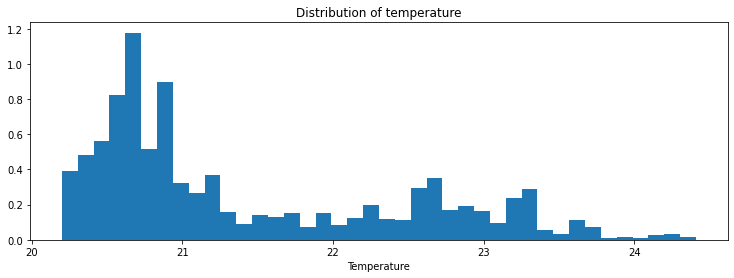

In [ ]:
figsize(12.5, 4)
plt.hist(df['Temperature'], bins=40, density=True, label='Temperature')
plt.xlabel('Temperature')
plt.title('Distribution of temperature')
plt.show()

 Temperature has a heavy tail distribution. 

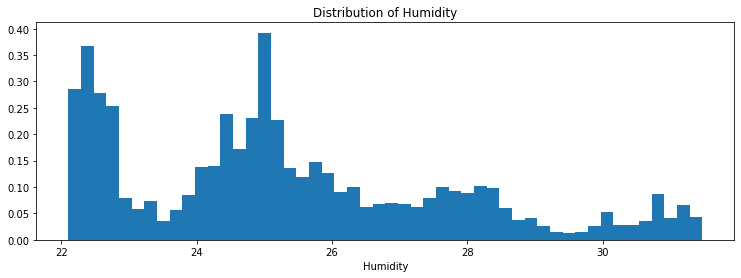

In [ ]:
figsize(12.5, 4)
plt.hist(df['Humidity'], bins=50, density=True, label='Humidity')
plt.xlabel('Humidity')
plt.title('Distribution of Humidity')
plt.show()

There are two peaks around 22.5 and 25.

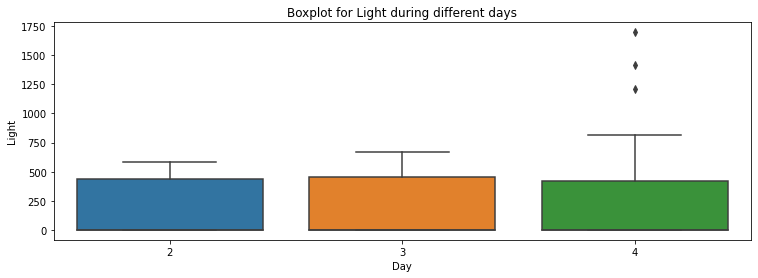

In [ ]:
figsize(12.5, 4)
seaborn.boxplot(x=df['date'].dt.day,y=df['Light'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Light during different days')
plt.show()

Distributions of light are almost identical during these three days.

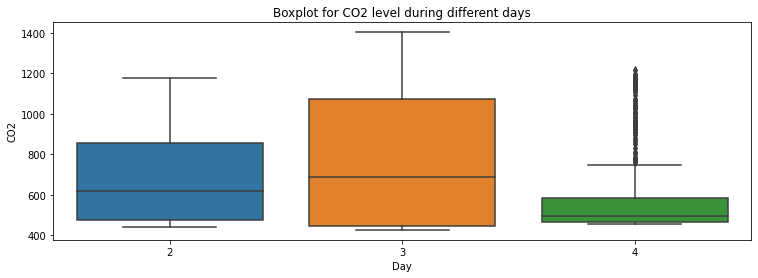

In [ ]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['CO2'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for CO2 level during different days')
plt.show()

These distributions are significantly different. There are lots of outliers on 2/4/2015

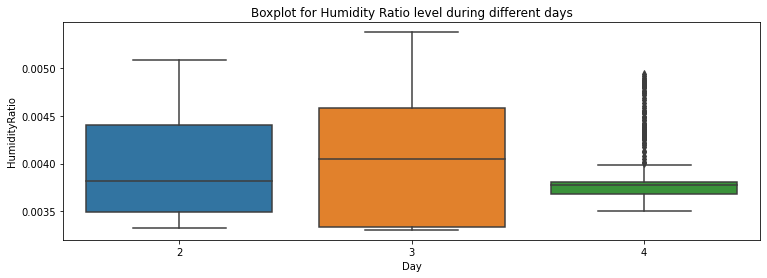

In [ ]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['HumidityRatio'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Humidity Ratio level during different days')
plt.show()

This looks pretty much similar to the boxplot for the CO2 level. Maybe, there is a 
strong correlation between the CO2 level and Humidity Ratio

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


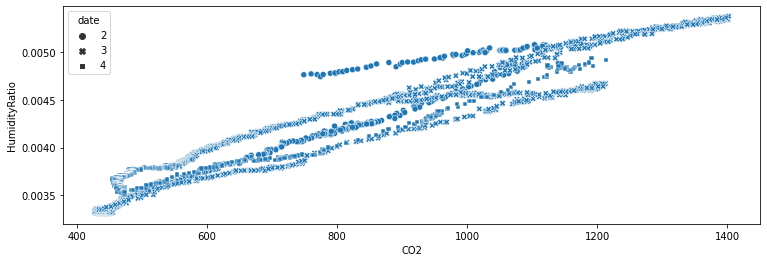

In [ ]:
ax=sns.scatterplot(df['CO2'], df['HumidityRatio'], style=df['date'].dt.day)

Indeed, there is a strong linear relationship between the CO2 level and the Humidity Ratio. 
Let us take an overview of the relation between our variables

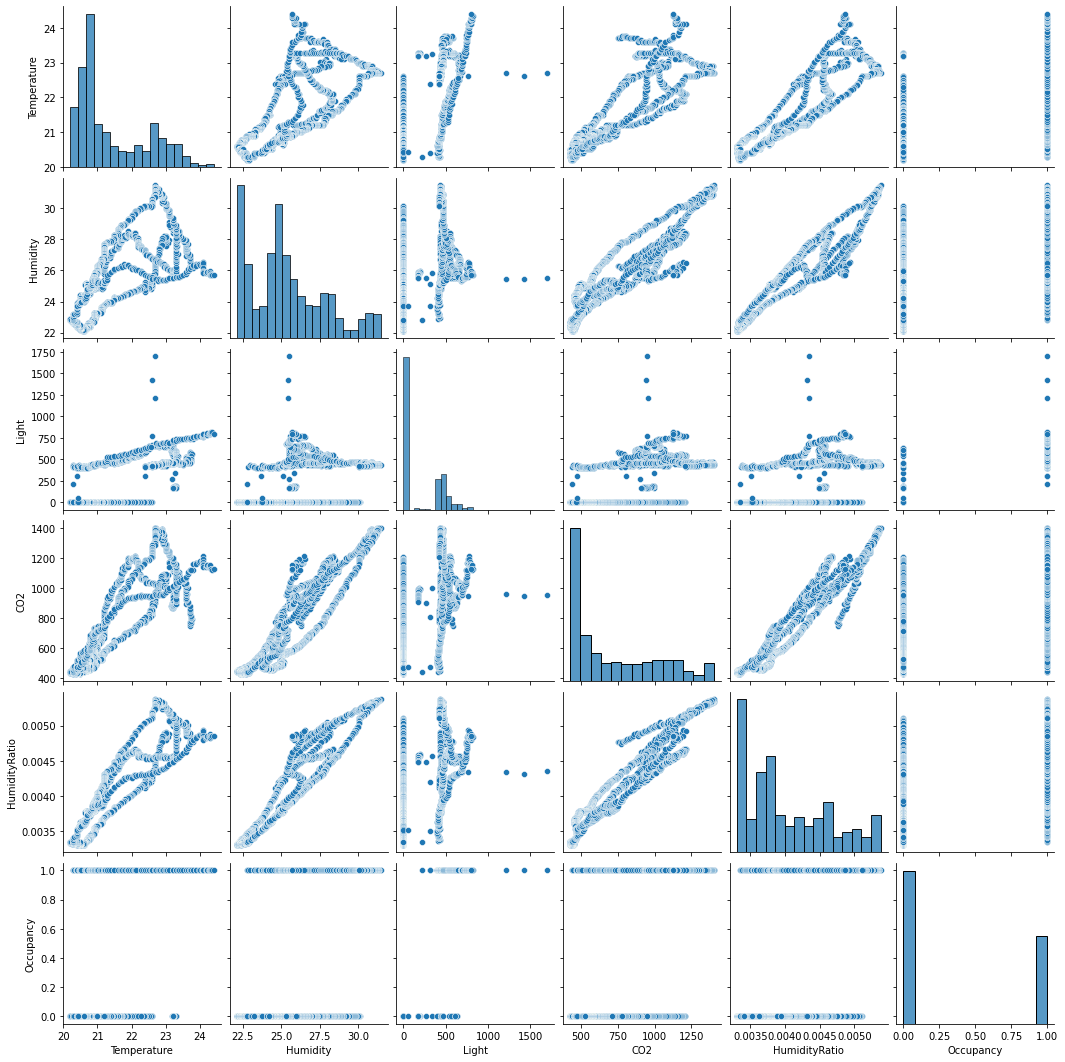

In [ ]:
ax=seaborn.pairplot(df)

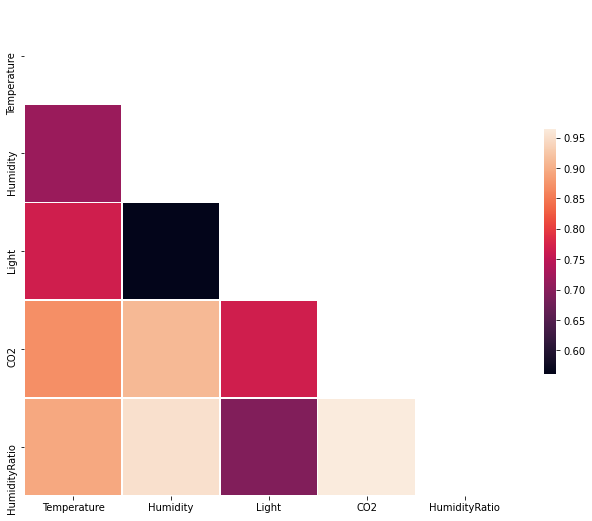

In [ ]:
corr=df.iloc[:, 1:-1].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It is clearly shown that the two pairs Humidity-Humidity Ration and 
Humidity Ratio-CO2 express the strongest linear relationship

## Bayesian logistic models with PyMC3

We will build several machine learning models to classify Occupancy based on other variables.

Recall that we have a binary decision problem. In other words, our target variable is assumed to follow a Bernoulli random variable with p given by:
$p = logit(B_0 + \sum_{var} B_{var}var), logit(p) = -ln(p/(1-p))$

To build a Bayesian logistic regression model, we first have to put a prior distribution on each parameter. The choice of these priors will affect the outcome (though with more data, they probably will “converge” to the same distribution.)

Once our priors are specified, PyMC3 will numerically approximate the posterior distributions using Markov Chain Monte Carlo simulations and its generalizations. We can then use samples from these posteriors to make inferences.

## Model with priors having normal distributions.
We can assume that the coefficients follow normal distributions. 

In [ ]:
with pm.Model() as second_model: 
    #priors with normal distribution    
    beta_0=pm.Normal('beta_0', mu=0, sd=10**4)
    beta_temp=pm.Normal('beta_temp', mu=0, sd=10**4)
    beta_humid=pm.Normal('beta_humid', mu=0, sd=10**4)
    beta_light=pm.Normal('beta_light', mu=0, sd=10**4)
    beta_co2=pm.Normal('beta_co2', mu=0, sd=10**4)
    beta_humid_ratio=pm.Normal('beta_humid_ration', mu=0, sd=10**4)    
    #probability of belonging to class 1    
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                                            beta_humid*df['Humidity']+
                                            beta_light*df['Light']+
                                            beta_co2*df['CO2']+
                                            beta_humid_ratio*df['HumidityRatio']))

Reproduce a vector of random parameters, p, from synthesized “observed data”, df[occupancy]

In [ ]:

#fit observed data into the model
with second_model:
  observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
  start=pm.find_MAP()
  step=pm.Metropolis()
  second_trace = pm.sample(2500,progressbar=True, target_accept=0.97,chains=4, tune=1500, random_seed=12345)
  #second_trace = pm.sample(25000) 

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -254.21, ||grad|| = 1,408.7: 100%|██████████| 61/61 [00:00<00:00, 877.72it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_humid_ration, beta_co2, beta_light, beta_humid, beta_temp, beta_0]
 11%|█         | 433/4000 [01:35<16:10,  3.68it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 11%|█         | 433/4000 [01:35<13:08,  4.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
second_burned_trace=second_trace[15000:]

In [ ]:
#observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
#start=pm.find_MAP()
#step=pm.Metropolis()
#second_trace = pm.sample(2500,progressbar=True, target_accept=0.97,chains=4, tune=1500, random_seed=12345)
#second_trace = pm.sample(25000,step=step,start=start,progressbar=True, chains=4, tune=2000, random_seed=12345)
#second_trace=pm.sample(25000, step=step, start=start)
    #second_burned_trace=second_trace[15000:]

In [ ]:
print(pm.summary(second_burned_trace, varnames=['p']))

TypeError: ignored

In [ ]:
print(pm.rhat(second_burned_trace,var_names=['p']))

AttributeError: ignored

In [ ]:
import arviz as az

In [ ]:
pm.traceplot(second_burned_trace)
plt.show()

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


AttributeError: ignored